In [1]:
import numpy
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
from numba import njit
import time

In [2]:
nx = 41
ny = 41
nt = 500
nit = 50
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
x = numpy.linspace(0, 2, nx)
y = numpy.linspace(0, 2, ny)
X, Y = numpy.meshgrid(x, y)

rho = 1
nu = .1
dt = .001

u = numpy.zeros((ny, nx))
v = numpy.zeros((ny, nx))
p = numpy.zeros((ny, nx)) 
b = numpy.zeros((ny, nx))

In [3]:
@njit
def build_up_b(b, rho, dt, u, v, dx, dy):
    row, col = p.shape
        
        
    for j in range(2, row):
        for i in range(2, col):
            b[j-1, i-1] = (rho * (1 / dt * 
                            ((u[j-1, i] - u[j-1, i-2]) / 
                             (2 * dx) + (v[j, i-1] - v[j-2, i-1]) / (2 * dy)) -
                            ((u[j-1, i] - u[j-1, i-2]) / (2 * dx))**2 -
                              2 * ((u[j, i-1] - u[j-2, i-1]) / (2 * dy) *
                                   (v[j-1, i] - v[j-1, i-2]) / (2 * dx))-
                                  ((v[j, i-1] - v[j-2, i-1]) / (2 * dy))**2))

    return b

In [4]:
@njit
def pressure_poisson(p, dx, dy, b):
    pn = numpy.empty_like(p)
    pn = p.copy()
    
    for q in range(nit):
        pn = p.copy()
        row, col = p.shape
        
        
        for j in range(2, row):
            for i in range(2, col):
                p[j-1, i-1] = (((pn[j-1, i] + pn[j-1, i-2]) * dy**2 + 
                                  (pn[j, i-1] + pn[j-2, i-1]) * dx**2) /
                                  (2 * (dx**2 + dy**2)) -
                                  dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                                  b[j-1, i-1])

        p[:, -1] = p[:, -2] # dp/dx = 0 at x = 2
        p[0, :] = p[1, :]   # dp/dy = 0 at y = 0
        p[:, 0] = p[:, 1]   # dp/dx = 0 at x = 0
        p[-1, :] = 0        # p = 0 at y = 2
        
    return p

In [5]:
@njit
def cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu):
    un = numpy.empty_like(u)
    vn = numpy.empty_like(v)
    b = numpy.zeros((ny, nx))
    
    for n in range(nt):
        un = u.copy()
        vn = v.copy()
        
        b = build_up_b(b, rho, dt, u, v, dx, dy)
        p = pressure_poisson(p, dx, dy, b)
        row, col = p.shape
        
        
        for j in range(2, row):
            for i in range(2, col):
                u[j-1, i-1] = (un[j-1, i-1]-
                                 un[j-1, i-1] * dt / dx *
                                (un[j-1, i-1] - un[j-1, i-2]) -
                                 vn[j-1, i-1] * dt / dy *
                                (un[j-1, i-1] - un[j-2, i-1]) -
                                 dt / (2 * rho * dx) * (p[j-1, i] - p[j-1, i-2]) +
                                 nu * (dt / dx**2 *
                                (un[j-1, i] - 2 * un[j-1, i-1] + un[j-1, i-2]) +
                                 dt / dy**2 *
                                (un[j, i-1] - 2 * un[j-1, i-1] + un[j-2, i-1])))
        
                v[j-1, i-1] = (vn[j-1, i-1] -
                                un[j-1, i-1] * dt / dx *
                               (vn[j-1, i-1] - vn[j-1, i-2]) -
                                vn[j-1, i-1] * dt / dy *
                               (vn[j-1, i-1] - vn[j-2, i-1]) -
                                dt / (2 * rho * dy) * (p[j, i-1] - p[j-2, i-1]) +
                                nu * (dt / dx**2 *
                               (vn[j-1, i] - 2 * vn[j-1, i-1] + vn[j-1, i-2]) +
                                dt / dy**2 *
                               (vn[j, i-1] - 2 * vn[j-1, i-1] + vn[j-2, i-1])))

        u[0, :]  = 0
        u[:, 0]  = 0
        u[:, -1] = 0
        u[-1, :] = 1    # set velocity on cavity lid equal to 1
        v[0, :]  = 0
        v[-1, :] = 0
        v[:, 0]  = 0
        v[:, -1] = 0
        
        
    return u, v, p

In [6]:
#compute the cpu time of the solving 2d Burgers equation
start = time.time()
start = time.time()
u, v, p = cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu)
end = time.time()        
print("Execution time is : {msec} ms".format(msec=(end-start)*1000) )    

Execution time is : 2211.7831707000732 ms


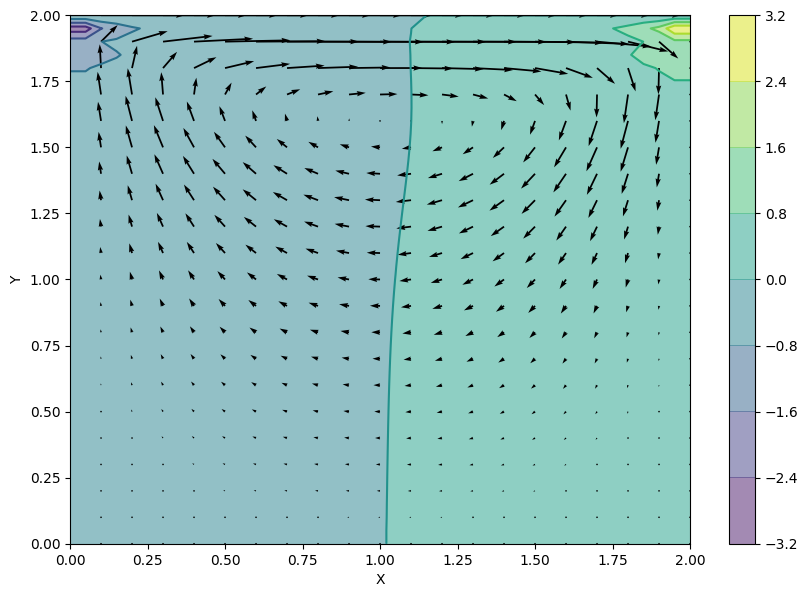

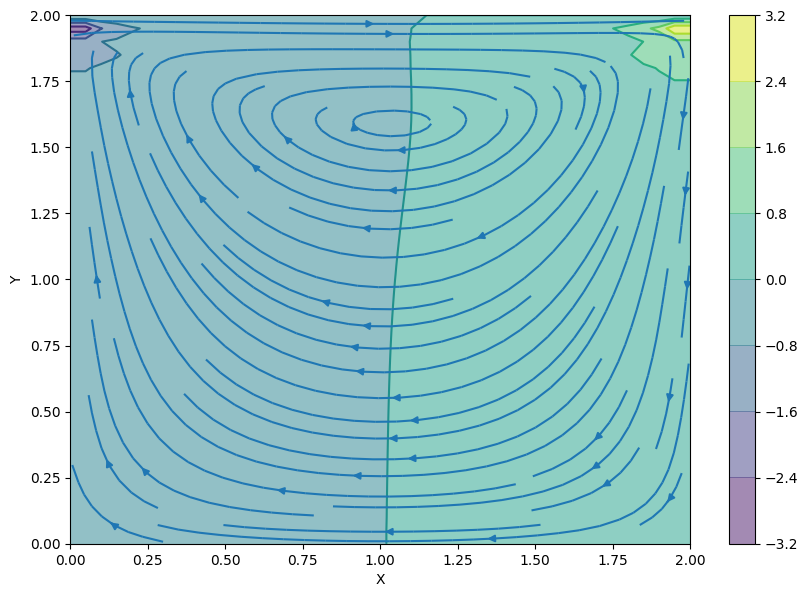

In [7]:
fig = pyplot.figure(figsize=(10, 7), dpi=100)
pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
pyplot.colorbar()
pyplot.contour(X, Y, p, cmap=cm.viridis)
pyplot.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2])
pyplot.xlabel('X')
pyplot.ylabel('Y');


fig = pyplot.figure(figsize=(10, 7), dpi=100)
pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
pyplot.colorbar()
pyplot.contour(X, Y, p, cmap=cm.viridis)
pyplot.streamplot(X, Y, u, v)
pyplot.xlabel('X')
pyplot.ylabel('Y');